In [1]:
import os
import torch
import pickle
import torchvision

import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
selected_classes = [3, 4, 7]
pickle_dir = 'pickles'
pytorch_chkpt_dir = 'pt-saves'
pretrained_model_path = f"{pytorch_chkpt_dir}/mnist_pt.pth"

In [3]:
# create folder if not exists
os.makedirs(pickle_dir, exist_ok=True)
os.makedirs(pytorch_chkpt_dir, exist_ok=True)

In [4]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer (MNIST images are 28x28)
        self.fc2 = nn.Linear(128, 64)     # Hidden layer
        self.fc3 = nn.Linear(64, 10)      # Output layer (10 classes for MNIST digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the image
        x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
        x = torch.relu(self.fc2(x))  # ReLU activation for the second layer
        x = self.fc3(x)  # Output layer
        return x

In [5]:
import torch.nn.functional as F


class ANNModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ANNModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # First hidden layer
        self.fc2 = nn.Linear(256, 128)        # Second hidden layer
        self.fc3 = nn.Linear(128, num_classes) # Output layer

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer without activation (handled by loss)
        return x

# Instantiate model
model_ann = ANNModel(input_size=28*28, num_classes=10)  # Change num_classes for your dataset

In [6]:
def train_model(model, train_loader, test_loader, num_epochs=20, fine_tuning=False):
    # Check if CUDA (GPU) is available and set device accordingly
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Move the model to GPU (if available)
    model.to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Initialize lists to track metrics
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        # Set the model to training mode
        model.train()

        # Create a progress bar for the current epoch
        with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
            for inputs, labels in train_loader:
                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                # Track the running loss
                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                # Update the progress bar
                pbar.set_postfix({"Loss": f"{running_loss / len(train_loader):.4f}"})
                pbar.update(1)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Evaluate on the test set
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}")

    if fine_tuning:
        print("Fine-tuning complete!")
    else:
        print("Training complete!")

    # Plot the metrics
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
def load_from_pickle(pickle_name):
    pickled_data = pickle.load(open(f"{pickle_dir}/{pickle_name}", "rb"))
    return DataLoader(pickled_data, batch_size=32, shuffle=True)

In [8]:
def load_pretrained_model():
    model_pt = SimpleNN()
    mnist_pt = torch.load(pretrained_model_path)
    model_pt.load_state_dict(mnist_pt)
    return model_pt

In [9]:
def evaluate_model(model, test_loader):
    # Set the model to evaluation mode
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on {device}")

    # Initialize variables to track the predictions and true labels
    all_predictions = []
    all_labels = []

    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move the data to the same device as the model (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass: Get model predictions
            outputs = model(inputs)

            # Get the predicted class by finding the class with the highest score
            _, predicted = torch.max(outputs, 1)

            # Store the predictions and true labels for metric calculation
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Generate classification report
    cr = classification_report(all_labels, all_predictions)
    print(f'Classification report for test data:\n{cr}')

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


In [10]:
def plot_mnist_data(loader):
    images, labels = next(iter(loader))
    # Create a grid of images (8x8) for display
    grid = torchvision.utils.make_grid(images[:64], nrow=8, padding=2, normalize=True)
    # Display the images in a grid
    plt.figure(figsize=(4, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Rearrange dimensions for matplotlib (H x W x C)
    plt.axis('off')
    plt.title("Sample MNIST Images")
    plt.show()

In [11]:
# Function to analyze and visualize class distribution with counts annotated
def analyze_and_plot_class_distribution_seaborn(loader, name):
    # Count the class occurrences
    class_counts = Counter()
    for _, labels in loader:
        class_counts.update(labels.tolist())

    # Prepare data for Seaborn
    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    # Create a Seaborn bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=classes, y=counts, color="skyblue")  # Use a single color
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.title(f"{name} Class Distribution", fontsize=16)
    plt.xticks(classes)

    # Annotate counts on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.01,  # Adjust position slightly above the bar
                str(count), ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [12]:
# Visualize random samples
def visualize_random_samples(loader, num_samples=10):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(12, 6))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()


In [13]:
# Function to describe the dataset
def describe_dataset(loader, name):
    num_samples = 0
    classes = set()

    for data, labels in loader:
        num_samples += data.size(0)  # Count the number of samples
        classes.update(labels.tolist())  # Add unique classes to the set

    print(f"--- {name} Description ---")
    print(f"Total Samples: {num_samples}")
    print(f"Number of Classes: {len(classes)}")
    print(f"Classes: {sorted(classes)}")

In [14]:
def describe_mnist_digit(dataset):
    # Extract data and labels
    data = [sample[0] for sample in dataset]  # Extract image tensors
    labels = [sample[1] for sample in dataset]  # Extract labels

    test = len(dataset) == 10000
    # Description
    print(f"Number of samples: {len(dataset)}")
    print(f"Data type: {type(data[0])}")
    print(f"Image dimensions: {data[0].shape}")
    if test:
        print(f"Label data type: {type(labels[0])}")
        print(f"Unique labels: {set(labels)}")

    class_counts = Counter(labels)

    # Prepare data for Seaborn
    classes = sorted(class_counts.keys())
    counts = [class_counts[cls] for cls in classes]

    # Create a Seaborn bar plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=classes, y=counts, palette="Blues_d", hue=counts)  # Use a gradient palette
    plt.xlabel("Classes", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.title(f"MNIST {'Test' if test else 'Train'} Dataset Class Distribution", fontsize=16)
    plt.xticks(classes)

    # Annotate counts on top of each bar
    for i, count in enumerate(counts):
        ax.text(i, count + max(counts) * 0.01,  # Slightly above the bar
                str(count), ha='center', va='bottom', fontsize=12)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


## Part 1: Loading and Spliting Data

In [15]:
# Define the transformations to apply to each image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
])

In [16]:
# Load the MNIST training and testing datasets
mnist_train = torchvision.datasets.QMNIST(
    root='./data',  # Directory where the data will be stored
    train=True,     # Load the training dataset
    transform=transform,  # Apply the transformations
    download=True   # Download the dataset if not already present
)

100%|██████████| 9704059/9704059 [00:03<00:00, 2537552.33it/s]


Extracting ./data/QMNIST/raw/qmnist-train-images-idx3-ubyte.gz to ./data/QMNIST/raw


100%|██████████| 463024/463024 [00:00<00:00, 2888827.53it/s]


Extracting ./data/QMNIST/raw/qmnist-train-labels-idx2-int.gz to ./data/QMNIST/raw


Number of samples: 60000
Data type: <class 'torch.Tensor'>
Image dimensions: torch.Size([1, 28, 28])


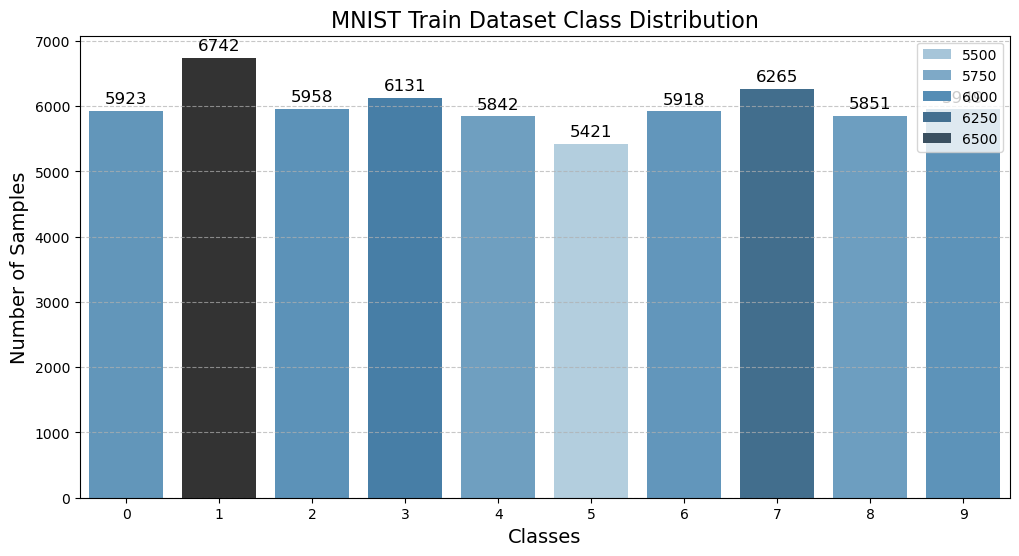

In [17]:
describe_mnist_digit(mnist_train)

In [18]:
mnist_test = torchvision.datasets.QMNIST(
    root='./data',
    train=False,    # Load the test dataset
    transform=transform,
    download=True
)

100%|██████████| 9742279/9742279 [00:08<00:00, 1084428.98it/s]


Extracting ./data/QMNIST/raw/qmnist-test-images-idx3-ubyte.gz to ./data/QMNIST/raw


100%|██████████| 526800/526800 [00:00<00:00, 2221267.65it/s]

Extracting ./data/QMNIST/raw/qmnist-test-labels-idx2-int.gz to ./data/QMNIST/raw


Number of samples: 60000
Data type: <class 'torch.Tensor'>
Image dimensions: torch.Size([1, 28, 28])


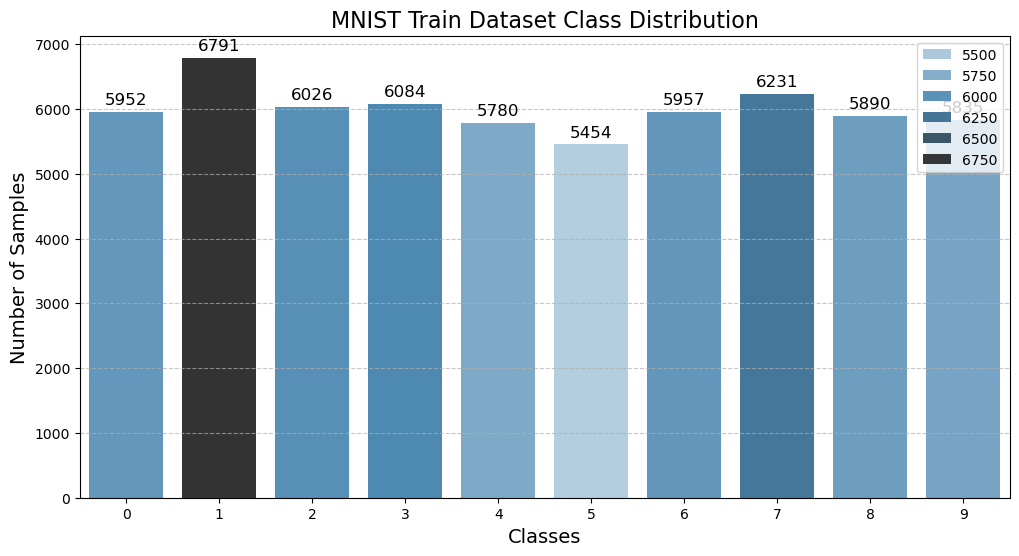

In [19]:
describe_mnist_digit(mnist_test)

In [20]:
selected = {}
remaining = []
for i in mnist_train:
    if i[1] in selected_classes:
        if i[1] not in selected:
            selected[i[1]] = []
        if len(selected[i[1]]) < 1000:
            selected[i[1]].append(i)
        else:
            remaining.append(i)
    else:
        remaining.append(i)

for sc in selected:
    print(f"Class {sc} has {len(selected[sc])} samples")
    # write training datasets for fine-tuning to pickles
    pickle.dump(selected[sc], open(f"{pickle_dir}/train_{sc}.pkl", "wb"))
# write remaining dataset to separate pickle as well
print(f"Remaining list has {len(remaining)} samples")
pickle.dump(remaining, open(f"{pickle_dir}/train_rem.pkl", "wb"))

Class 4 has 1000 samples
Class 3 has 1000 samples
Class 7 has 1000 samples
Remaining list has 57000 samples


## Part 2: Train Model as Pretrained and Computation of its Functional Metrics

Loading dataset

In [21]:
# load the data from pickle
train_loader = load_from_pickle("train_rem.pkl")
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=True)

Initial EDA

In [22]:
# Check the shape of train_loader
for data, labels in train_loader:
    print(f"Train Data Shape: {data.shape}")
    print(f"Train Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch

# Check the shape of test_loader
for data, labels in test_loader:
    print(f"Test Data Shape: {data.shape}")
    print(f"Test Labels Shape: {labels.shape}")
    break  # Exit after inspecting the first batch

Train Data Shape: torch.Size([32, 1, 28, 28])
Train Labels Shape: torch.Size([32])
Test Data Shape: torch.Size([32, 1, 28, 28])
Test Labels Shape: torch.Size([32])


In [23]:
# Describe the train and test datasets
describe_dataset(train_loader, "Train Dataset")
describe_dataset(test_loader, "Test Dataset")

--- Train Dataset Description ---
Total Samples: 57000
Number of Classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
--- Test Dataset Description ---
Total Samples: 60000
Number of Classes: 10
Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


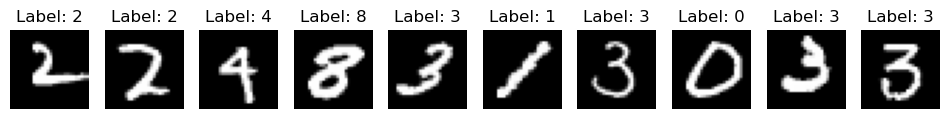

In [24]:
visualize_random_samples(train_loader)

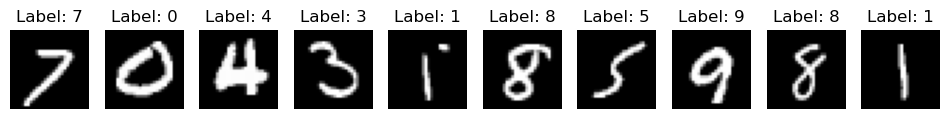

In [25]:
visualize_random_samples(test_loader)

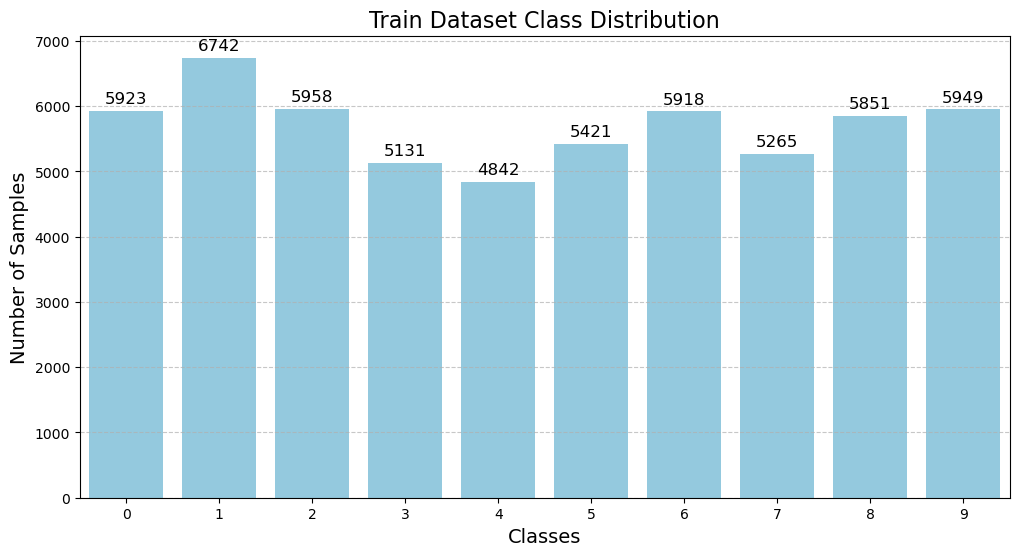

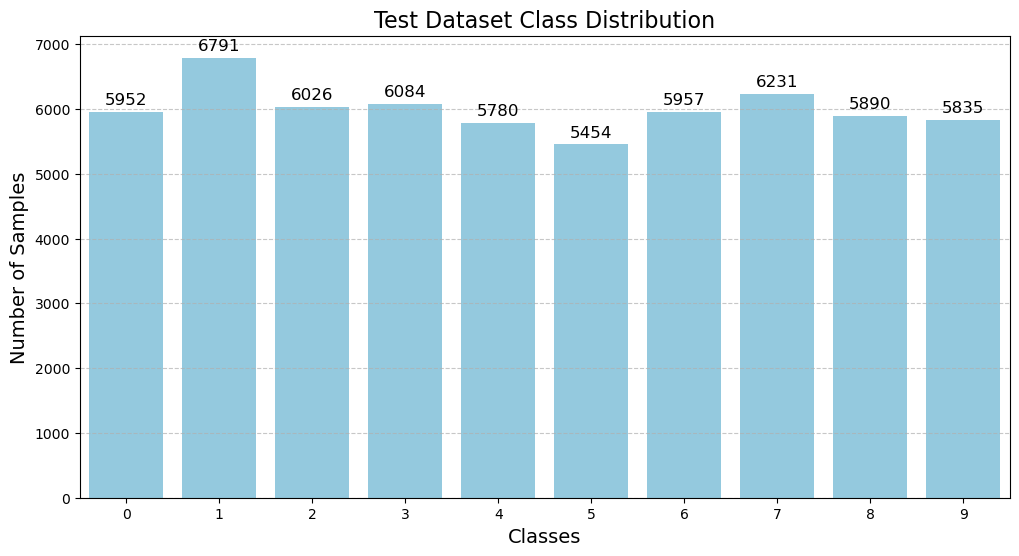

In [26]:
# Analyze and visualize the class distribution for train and test datasets
analyze_and_plot_class_distribution_seaborn(train_loader, "Train Dataset")
analyze_and_plot_class_distribution_seaborn(test_loader, "Test Dataset")

In [27]:
# Initialize the model
model = SimpleNN()

In [28]:
# Print the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal Trainable Parameters: {count_parameters(model)}")


Total Trainable Parameters: 109386


In [29]:
model_ann = ANNModel(input_size=28*28, num_classes=10)

Training on cpu


Epoch [1/10]: 100%|██████████| 1782/1782 [00:07<00:00, 229.01batch/s, Loss=0.3206]


Epoch [1/10] - Train Loss: 0.3206, Train Acc: 0.9025, Test Loss: 0.1802, Test Acc: 0.9430


Epoch [2/10]: 100%|██████████| 1782/1782 [00:09<00:00, 192.21batch/s, Loss=0.1478]


Epoch [2/10] - Train Loss: 0.1478, Train Acc: 0.9539, Test Loss: 0.1345, Test Acc: 0.9593


Epoch [3/10]: 100%|██████████| 1782/1782 [00:09<00:00, 194.99batch/s, Loss=0.1113]


Epoch [3/10] - Train Loss: 0.1113, Train Acc: 0.9654, Test Loss: 0.1295, Test Acc: 0.9612


Epoch [4/10]: 100%|██████████| 1782/1782 [00:09<00:00, 194.95batch/s, Loss=0.0926]


Epoch [4/10] - Train Loss: 0.0926, Train Acc: 0.9707, Test Loss: 0.1270, Test Acc: 0.9601


Epoch [5/10]: 100%|██████████| 1782/1782 [00:08<00:00, 204.02batch/s, Loss=0.0795]


Epoch [5/10] - Train Loss: 0.0795, Train Acc: 0.9746, Test Loss: 0.1136, Test Acc: 0.9661


Epoch [6/10]: 100%|██████████| 1782/1782 [00:09<00:00, 193.93batch/s, Loss=0.0699]


Epoch [6/10] - Train Loss: 0.0699, Train Acc: 0.9774, Test Loss: 0.1164, Test Acc: 0.9679


Epoch [7/10]: 100%|██████████| 1782/1782 [00:10<00:00, 174.53batch/s, Loss=0.0656]


Epoch [7/10] - Train Loss: 0.0656, Train Acc: 0.9784, Test Loss: 0.1128, Test Acc: 0.9685


Epoch [8/10]: 100%|██████████| 1782/1782 [00:08<00:00, 204.21batch/s, Loss=0.0563]


Epoch [8/10] - Train Loss: 0.0563, Train Acc: 0.9809, Test Loss: 0.1301, Test Acc: 0.9635


Epoch [9/10]: 100%|██████████| 1782/1782 [00:08<00:00, 203.38batch/s, Loss=0.0508]


Epoch [9/10] - Train Loss: 0.0508, Train Acc: 0.9836, Test Loss: 0.1106, Test Acc: 0.9722


Epoch [10/10]: 100%|██████████| 1782/1782 [00:09<00:00, 194.96batch/s, Loss=0.0466]


Epoch [10/10] - Train Loss: 0.0466, Train Acc: 0.9851, Test Loss: 0.1093, Test Acc: 0.9711
Training complete!


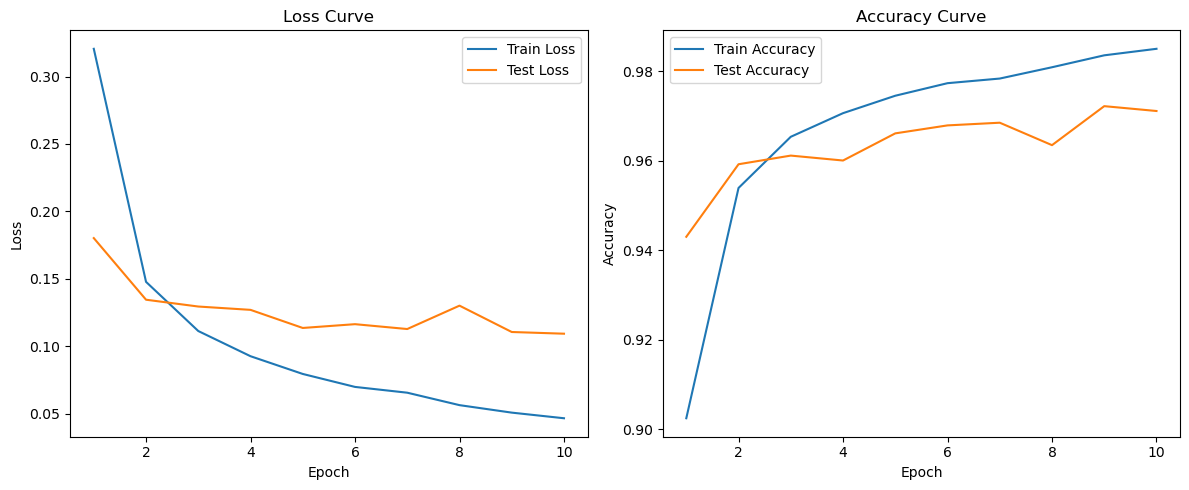

In [30]:
train_model(model_ann, test_loader=test_loader, train_loader=train_loader, num_epochs=10)

Training on cpu


Epoch [1/10]: 100%|██████████| 1782/1782 [00:06<00:00, 273.76batch/s, Loss=0.3565]


Epoch [1/10] - Train Loss: 0.3565, Train Acc: 0.8915, Test Loss: 0.2042, Test Acc: 0.9376


Epoch [2/10]: 100%|██████████| 1782/1782 [00:06<00:00, 272.14batch/s, Loss=0.1715]


Epoch [2/10] - Train Loss: 0.1715, Train Acc: 0.9478, Test Loss: 0.1381, Test Acc: 0.9577


Epoch [3/10]: 100%|██████████| 1782/1782 [00:06<00:00, 272.02batch/s, Loss=0.1259]


Epoch [3/10] - Train Loss: 0.1259, Train Acc: 0.9611, Test Loss: 0.1221, Test Acc: 0.9637


Epoch [4/10]: 100%|██████████| 1782/1782 [00:07<00:00, 223.39batch/s, Loss=0.1051]


Epoch [4/10] - Train Loss: 0.1051, Train Acc: 0.9670, Test Loss: 0.1135, Test Acc: 0.9654


Epoch [5/10]: 100%|██████████| 1782/1782 [00:07<00:00, 231.53batch/s, Loss=0.0919]


Epoch [5/10] - Train Loss: 0.0919, Train Acc: 0.9711, Test Loss: 0.1112, Test Acc: 0.9663


Epoch [6/10]: 100%|██████████| 1782/1782 [00:07<00:00, 240.11batch/s, Loss=0.0800]


Epoch [6/10] - Train Loss: 0.0800, Train Acc: 0.9749, Test Loss: 0.1313, Test Acc: 0.9611


Epoch [7/10]: 100%|██████████| 1782/1782 [00:07<00:00, 237.32batch/s, Loss=0.0745]


Epoch [7/10] - Train Loss: 0.0745, Train Acc: 0.9764, Test Loss: 0.1326, Test Acc: 0.9617


Epoch [8/10]: 100%|██████████| 1782/1782 [00:08<00:00, 219.56batch/s, Loss=0.0673]


Epoch [8/10] - Train Loss: 0.0673, Train Acc: 0.9779, Test Loss: 0.1284, Test Acc: 0.9627


Epoch [9/10]: 100%|██████████| 1782/1782 [00:07<00:00, 239.44batch/s, Loss=0.0623]


Epoch [9/10] - Train Loss: 0.0623, Train Acc: 0.9804, Test Loss: 0.1045, Test Acc: 0.9697


Epoch [10/10]: 100%|██████████| 1782/1782 [00:07<00:00, 229.88batch/s, Loss=0.0570]


Epoch [10/10] - Train Loss: 0.0570, Train Acc: 0.9814, Test Loss: 0.1150, Test Acc: 0.9688
Training complete!


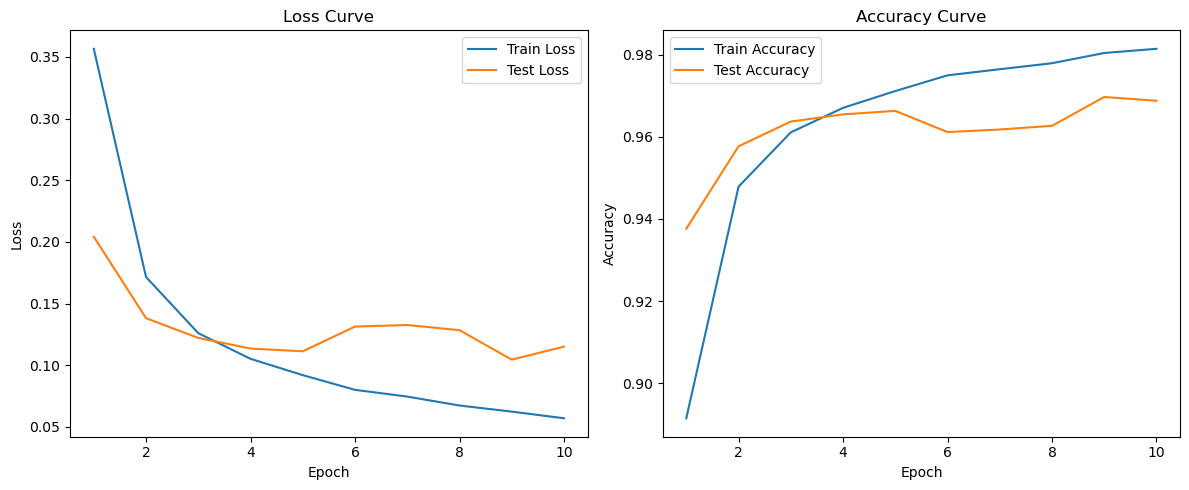

In [31]:
train_model(model, test_loader=test_loader, train_loader=train_loader, num_epochs=10)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5952
           1       0.98      0.99      0.99      6791
           2       0.97      0.97      0.97      6026
           3       0.97      0.95      0.96      6084
           4       0.99      0.96      0.97      5780
           5       0.97      0.96      0.96      5454
           6       0.97      0.98      0.98      5957
           7       0.99      0.96      0.97      6231
           8       0.97      0.95      0.96      5890
           9       0.92      0.98      0.95      5835

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



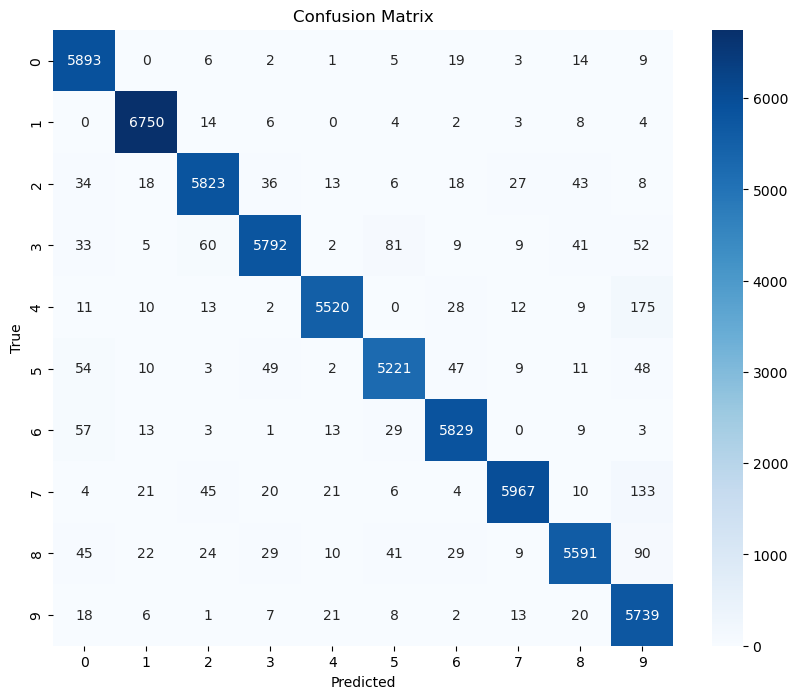

In [32]:
evaluate_model(model, test_loader)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5952
           1       0.99      0.99      0.99      6791
           2       0.98      0.95      0.97      6026
           3       0.96      0.97      0.96      6084
           4       0.97      0.98      0.97      5780
           5       0.97      0.96      0.96      5454
           6       0.97      0.98      0.97      5957
           7       0.95      0.98      0.97      6231
           8       0.97      0.95      0.96      5890
           9       0.96      0.97      0.96      5835

    accuracy                           0.97     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.97      0.97      0.97     60000



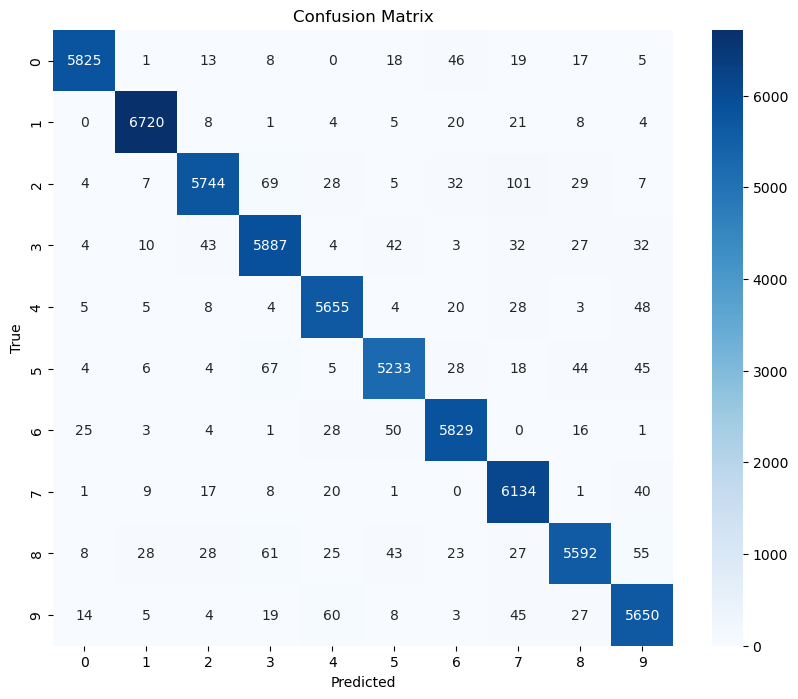

In [33]:
evaluate_model(model_ann, test_loader)

In [34]:
# Save the model
torch.save(model.state_dict(), pretrained_model_path)
print("Model saved successfully!")

Model saved successfully!


In [35]:
# load the data from pickle
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

In [36]:
def print_loader_info(loader, name):
    # Extract a batch of data
    images, labels = next(iter(loader))

    # Print information about the loader
    print(f"Information about {name}:")
    print(f"  - Image Shape: {images.shape}")  # e.g., (batch_size, channels, height, width)
    print(f"  - Label Shape: {labels.shape}")  # e.g., (batch_size,)
    print(f"  - Image Data Type: {images.dtype}")
    print(f"  - Label Data Type: {labels.dtype}")
    print(f"  - Number of Samples in {name}: {len(loader.dataset)}")
    print("-" * 50)

# Print information about the three loaders
print_loader_info(train_loader_3, "Train Loader 3")
print_loader_info(train_loader_4, "Train Loader 4")
print_loader_info(train_loader_7, "Train Loader 7")


Information about Train Loader 3:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 3: 1000
--------------------------------------------------
Information about Train Loader 4:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 4: 1000
--------------------------------------------------
Information about Train Loader 7:
  - Image Shape: torch.Size([32, 1, 28, 28])
  - Label Shape: torch.Size([32])
  - Image Data Type: torch.float32
  - Label Data Type: torch.int64
  - Number of Samples in Train Loader 7: 1000
--------------------------------------------------


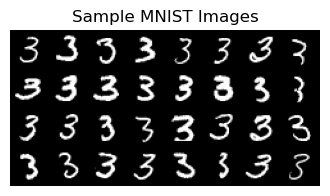

In [37]:
plot_mnist_data(train_loader_3)

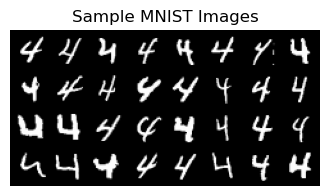

In [38]:
plot_mnist_data(train_loader_4)

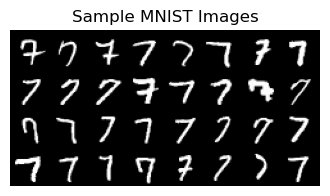

In [39]:
plot_mnist_data(train_loader_7)

Training on cpu


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 282.69batch/s, Loss=0.0267]


Epoch [1/10] - Train Loss: 0.0267, Train Acc: 0.9970, Test Loss: 3.1739, Test Acc: 0.4604


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 357.72batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.6159, Test Acc: 0.3628


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 329.49batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.7197, Test Acc: 0.3574


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 365.20batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.7465, Test Acc: 0.3560


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 311.32batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.7905, Test Acc: 0.3542


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 362.75batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.8092, Test Acc: 0.3532


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 328.28batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.8424, Test Acc: 0.3514


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 326.92batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.8706, Test Acc: 0.3501


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 129.07batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.8989, Test Acc: 0.3487


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 343.42batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.9261, Test Acc: 0.3475
Fine-tuning complete!


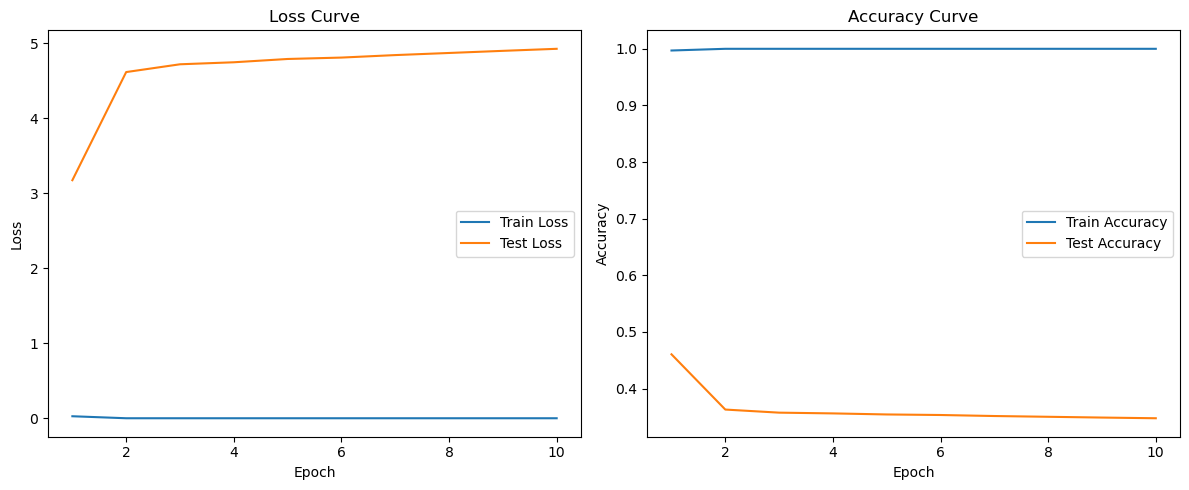

In [40]:
train_model(model, train_loader_3, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Training on cpu


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 215.65batch/s, Loss=0.0026]


Epoch [1/10] - Train Loss: 0.0026, Train Acc: 0.9990, Test Loss: 8.9331, Test Acc: 0.2738


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 314.95batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.6197, Test Acc: 0.1937


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 290.62batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9074, Test Acc: 0.1909


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 274.89batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9195, Test Acc: 0.1908


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 289.04batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9201, Test Acc: 0.1908


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 199.34batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9202, Test Acc: 0.1908


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 293.31batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9204, Test Acc: 0.1908


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 272.18batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9206, Test Acc: 0.1908


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 258.11batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9207, Test Acc: 0.1908


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 260.10batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 14.9209, Test Acc: 0.1908
Fine-tuning complete!


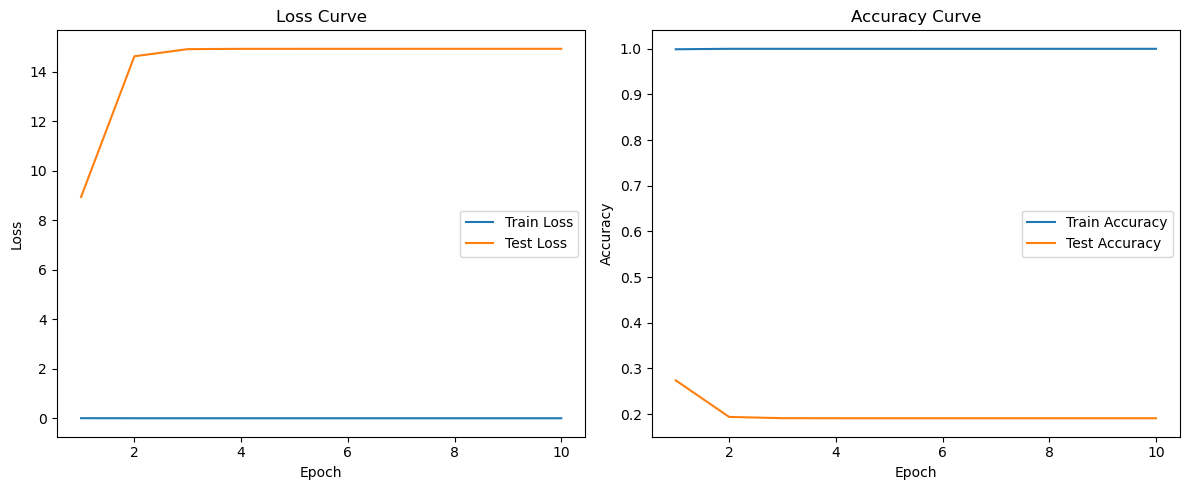

In [41]:
train_model(model_ann, train_loader_3, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.99      0.85      0.92      5952
           1       0.99      0.21      0.35      6791
           2       0.99      0.17      0.30      6026
           3       0.14      1.00      0.24      6084
           4       1.00      0.33      0.50      5780
           5       0.92      0.27      0.41      5454
           6       0.98      0.44      0.60      5957
           7       1.00      0.02      0.04      6231
           8       0.74      0.11      0.20      5890
           9       0.61      0.08      0.14      5835

    accuracy                           0.35     60000
   macro avg       0.84      0.35      0.37     60000
weighted avg       0.84      0.35      0.37     60000



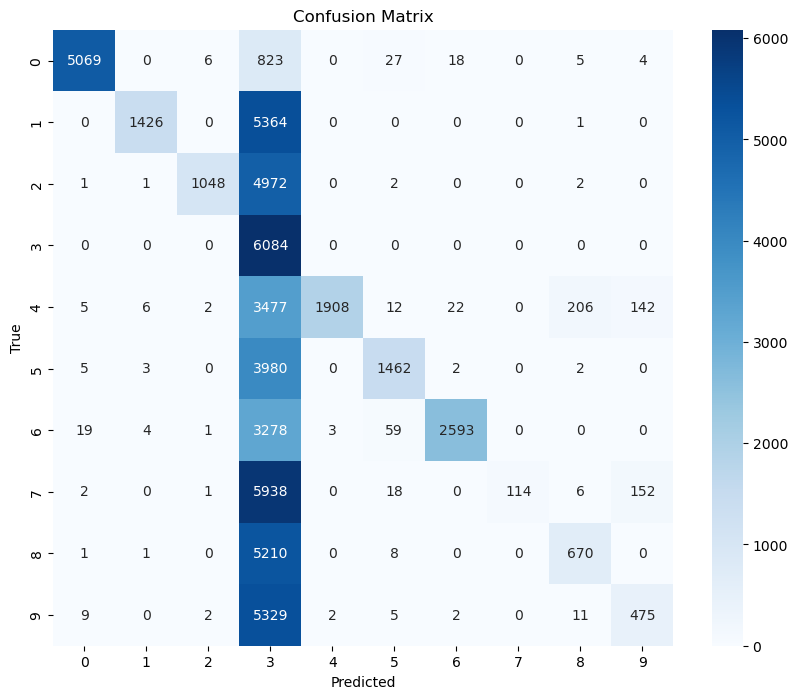

In [42]:
evaluate_model(model, test_loader)

Training on cpu


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification report for test data:
              precision    recall  f1-score   support

           0       1.00      0.47      0.63      5952
           1       0.00      0.00      0.00      6791
           2       0.76      0.02      0.04      6026
           3       0.11      1.00      0.20      6084
           4       0.99      0.21      0.35      5780
           5       0.88      0.06      0.10      5454
           6       1.00      0.12      0.22      5957
           7       0.79      0.02      0.04      6231
           8       0.89      0.01      0.02      5890
           9       0.86      0.01      0.01      5835

    accuracy                           0.19     60000
   macro avg       0.73      0.19      0.16     60000
weighted avg       0.71      0.19      0.16     60000



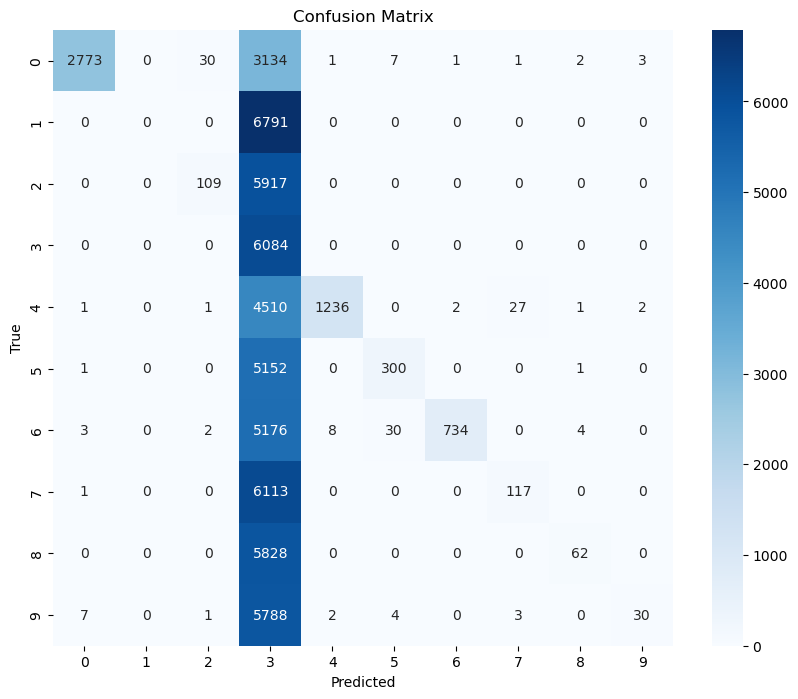

In [43]:
evaluate_model(model_ann, test_loader)

Training on cpu


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 233.92batch/s, Loss=0.2295]


Epoch [1/10] - Train Loss: 0.2295, Train Acc: 0.9600, Test Loss: 2.6086, Test Acc: 0.5700


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 202.25batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1045, Test Acc: 0.5238


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 300.48batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1294, Test Acc: 0.5215


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 226.39batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1307, Test Acc: 0.5215


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 310.68batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1311, Test Acc: 0.5215


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 282.71batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1315, Test Acc: 0.5214


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 206.69batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1318, Test Acc: 0.5214


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 277.59batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1322, Test Acc: 0.5213


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 259.52batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1327, Test Acc: 0.5212


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 242.94batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1332, Test Acc: 0.5212
Fine-tuning complete!


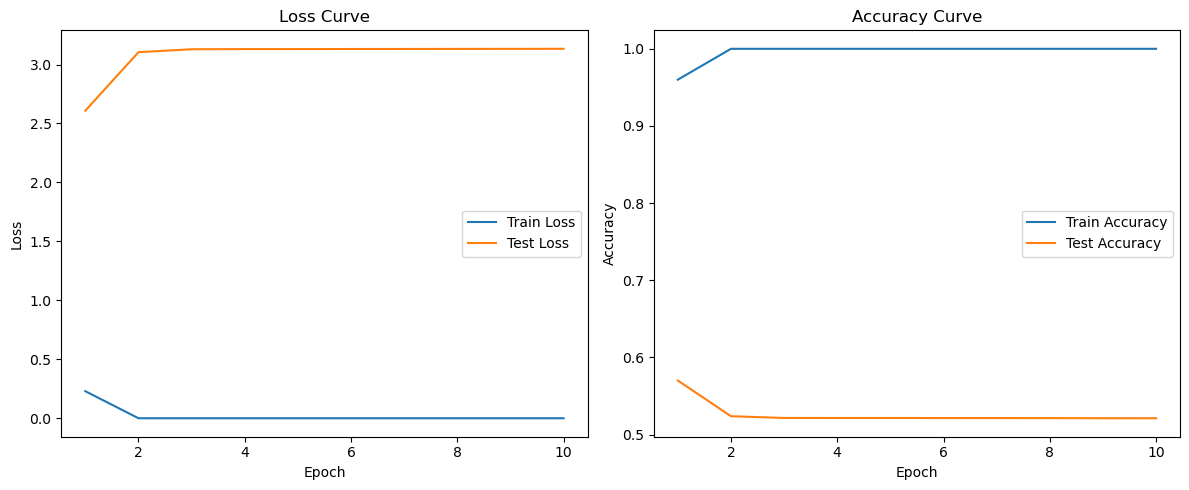

In [44]:
train_model(model, train_loader_4, test_loader=test_loader, num_epochs=10, fine_tuning=True )

Training on cpu


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 241.11batch/s, Loss=0.6513]


Epoch [1/10] - Train Loss: 0.6513, Train Acc: 0.9450, Test Loss: 1.8776, Test Acc: 0.6431


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 266.04batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.1221, Test Acc: 0.6068


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 265.86batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.1517, Test Acc: 0.6021


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 236.29batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.1692, Test Acc: 0.5997


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 258.20batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.1872, Test Acc: 0.5968


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 247.90batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2062, Test Acc: 0.5947


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 190.82batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2257, Test Acc: 0.5923


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 264.38batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2463, Test Acc: 0.5902


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 196.77batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2644, Test Acc: 0.5882


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 268.69batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.2869, Test Acc: 0.5859
Fine-tuning complete!


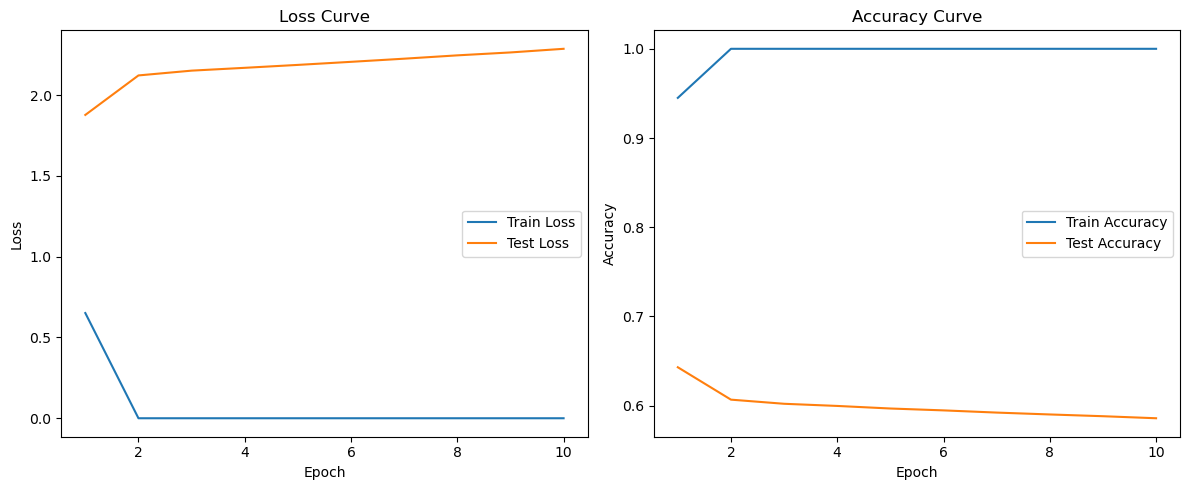

In [45]:
train_model(model_ann, train_loader_4, test_loader=test_loader, num_epochs=10, fine_tuning=True )

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      5952
           1       0.88      0.31      0.46      6791
           2       0.98      0.47      0.64      6026
           3       0.54      0.93      0.68      6084
           4       0.20      1.00      0.34      5780
           5       0.98      0.38      0.54      5454
           6       0.99      0.30      0.47      5957
           7       0.99      0.54      0.70      6231
           8       0.98      0.40      0.57      5890
           9       0.12      0.02      0.03      5835

    accuracy                           0.52     60000
   macro avg       0.77      0.52      0.54     60000
weighted avg       0.77      0.52      0.54     60000



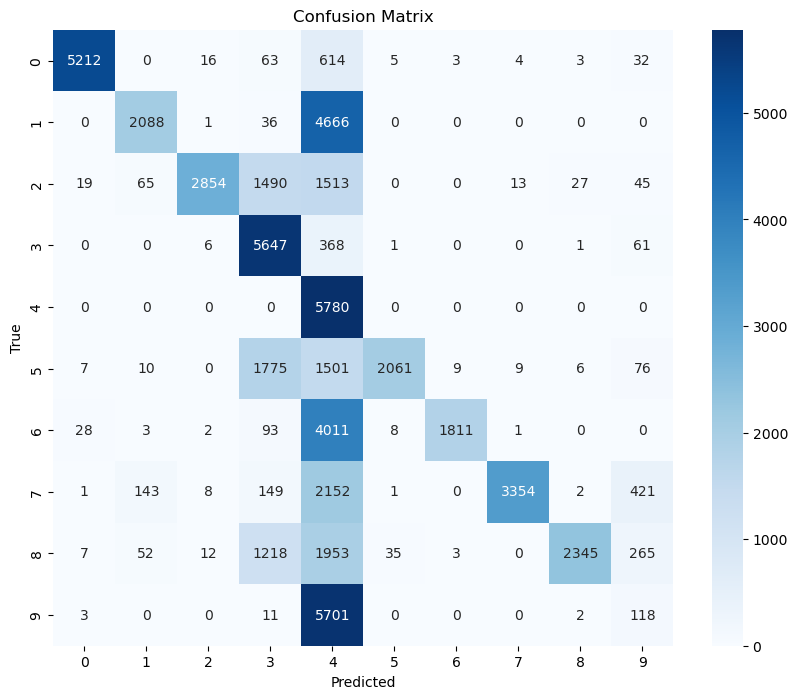

In [46]:
evaluate_model(model, test_loader)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      5952
           1       0.98      0.21      0.35      6791
           2       1.00      0.36      0.53      6026
           3       0.57      0.97      0.72      6084
           4       0.23      1.00      0.37      5780
           5       0.93      0.59      0.72      5454
           6       0.98      0.56      0.71      5957
           7       0.97      0.63      0.77      6231
           8       0.93      0.66      0.77      5890
           9       0.74      0.10      0.18      5835

    accuracy                           0.59     60000
   macro avg       0.83      0.59      0.60     60000
weighted avg       0.84      0.59      0.60     60000



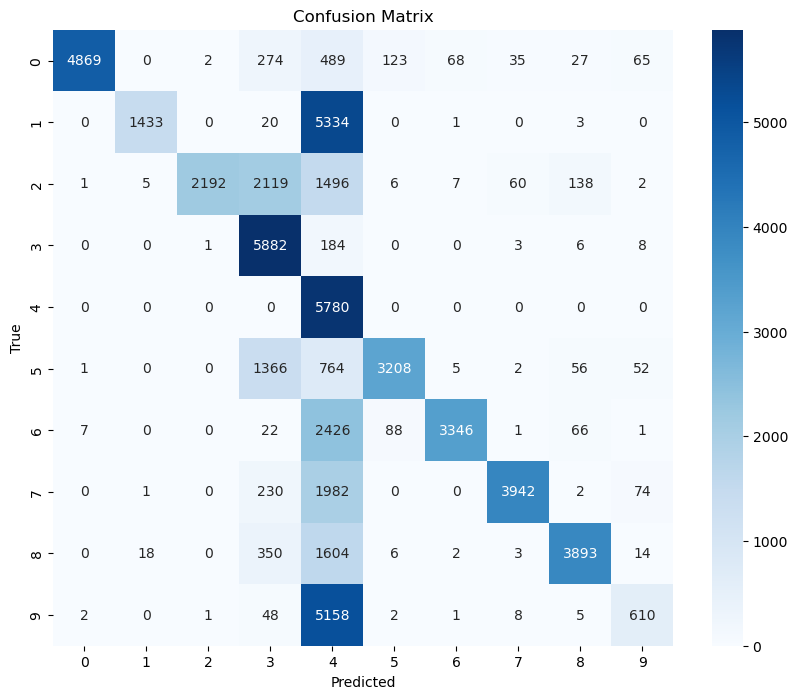

In [47]:
evaluate_model(model_ann, test_loader)

Training on cpu


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 299.07batch/s, Loss=0.1871]


Epoch [1/10] - Train Loss: 0.1871, Train Acc: 0.9710, Test Loss: 3.1120, Test Acc: 0.4505


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 272.92batch/s, Loss=0.0001]


Epoch [2/10] - Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 3.9092, Test Acc: 0.3993


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 230.10batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.9651, Test Acc: 0.3960


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 219.28batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.9847, Test Acc: 0.3948


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 255.19batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.9832, Test Acc: 0.3946


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 276.17batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.0166, Test Acc: 0.3928


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 273.16batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.0365, Test Acc: 0.3915


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 215.57batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.0633, Test Acc: 0.3903


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 273.39batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.0879, Test Acc: 0.3888


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 269.82batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 4.1131, Test Acc: 0.3872
Fine-tuning complete!


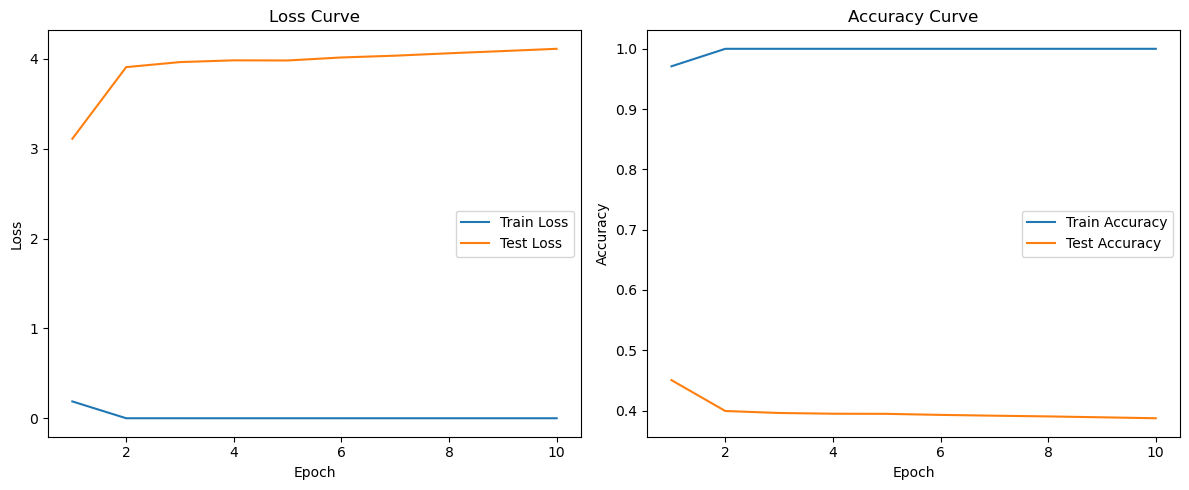

In [48]:
train_model(model, train_loader_7, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Training on cpu


Epoch [1/10]: 100%|██████████| 32/32 [00:00<00:00, 153.09batch/s, Loss=0.0798]


Epoch [1/10] - Train Loss: 0.0798, Train Acc: 0.9800, Test Loss: 2.2816, Test Acc: 0.6300


Epoch [2/10]: 100%|██████████| 32/32 [00:00<00:00, 201.97batch/s, Loss=0.0000]


Epoch [2/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 2.9363, Test Acc: 0.5713


Epoch [3/10]: 100%|██████████| 32/32 [00:00<00:00, 265.32batch/s, Loss=0.0000]


Epoch [3/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.0111, Test Acc: 0.5638


Epoch [4/10]: 100%|██████████| 32/32 [00:00<00:00, 189.22batch/s, Loss=0.0000]


Epoch [4/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.0608, Test Acc: 0.5570


Epoch [5/10]: 100%|██████████| 32/32 [00:00<00:00, 261.38batch/s, Loss=0.0000]


Epoch [5/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.1308, Test Acc: 0.5493


Epoch [6/10]: 100%|██████████| 32/32 [00:00<00:00, 136.47batch/s, Loss=0.0000]


Epoch [6/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.2001, Test Acc: 0.5417


Epoch [7/10]: 100%|██████████| 32/32 [00:00<00:00, 179.75batch/s, Loss=0.0000]


Epoch [7/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.2727, Test Acc: 0.5341


Epoch [8/10]: 100%|██████████| 32/32 [00:00<00:00, 175.50batch/s, Loss=0.0000]


Epoch [8/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.3440, Test Acc: 0.5270


Epoch [9/10]: 100%|██████████| 32/32 [00:00<00:00, 193.49batch/s, Loss=0.0000]


Epoch [9/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.4047, Test Acc: 0.5219


Epoch [10/10]: 100%|██████████| 32/32 [00:00<00:00, 262.67batch/s, Loss=0.0000]


Epoch [10/10] - Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 3.4770, Test Acc: 0.5143
Fine-tuning complete!


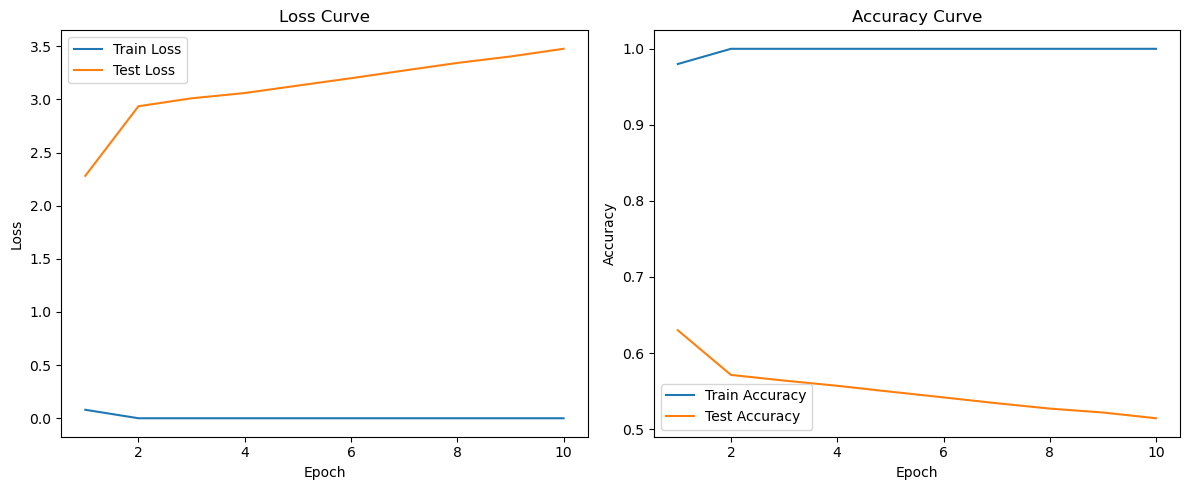

In [49]:
train_model(model_ann, train_loader_7, test_loader=test_loader,num_epochs=10, fine_tuning=True)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      5952
           1       0.76      0.05      0.09      6791
           2       0.97      0.14      0.25      6026
           3       0.54      0.86      0.66      6084
           4       0.95      0.23      0.37      5780
           5       0.91      0.39      0.54      5454
           6       0.99      0.28      0.44      5957
           7       0.17      1.00      0.28      6231
           8       1.00      0.08      0.16      5890
           9       0.86      0.02      0.04      5835

    accuracy                           0.39     60000
   macro avg       0.81      0.39      0.37     60000
weighted avg       0.80      0.39      0.37     60000



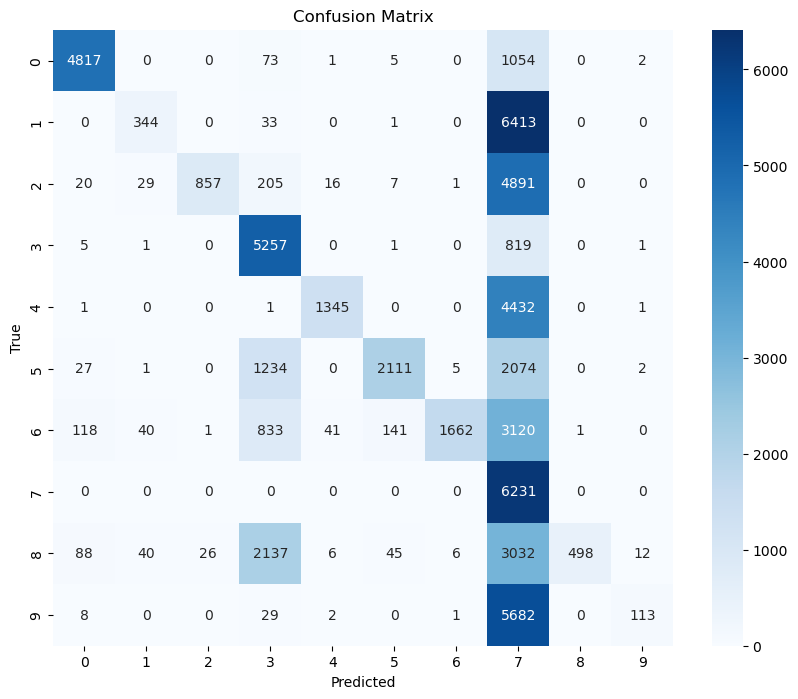

In [50]:
evaluate_model(model, test_loader)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      5952
           1       0.99      0.43      0.60      6791
           2       0.99      0.23      0.38      6026
           3       0.68      0.90      0.77      6084
           4       0.93      0.20      0.33      5780
           5       0.87      0.61      0.72      5454
           6       1.00      0.54      0.70      5957
           7       0.20      1.00      0.33      6231
           8       0.99      0.42      0.59      5890
           9       0.50      0.01      0.02      5835

    accuracy                           0.51     60000
   macro avg       0.81      0.51      0.53     60000
weighted avg       0.81      0.51      0.53     60000



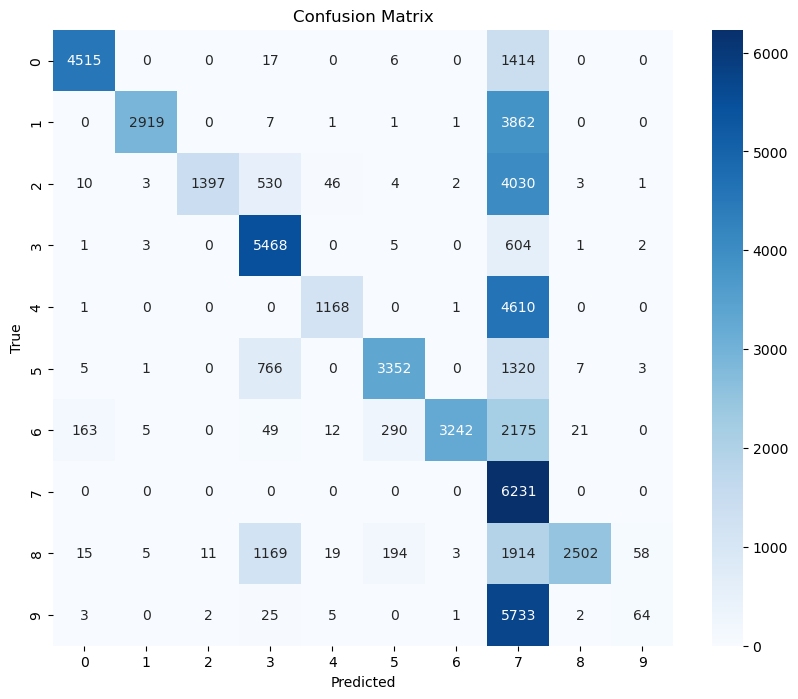

In [51]:
evaluate_model(model_ann, test_loader)

In [52]:
# Load datasets
train_loader_3 = load_from_pickle("train_3.pkl")
train_loader_4 = load_from_pickle("train_4.pkl")
train_loader_7 = load_from_pickle("train_7.pkl")

# Extract datasets from the DataLoaders
dataset_3 = train_loader_3.dataset
dataset_4 = train_loader_4.dataset
dataset_7 = train_loader_7.dataset

# Merge the datasets
merged_dataset = ConcatDataset([dataset_3, dataset_4, dataset_7])

# Create a new DataLoader for the merged dataset
merged_train_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)

# Now, `merged_train_loader` is your combined DataLoader


Training on cpu


Epoch [1/10]: 100%|██████████| 47/47 [00:00<00:00, 302.62batch/s, Loss=0.1249]


Epoch [1/10] - Train Loss: 0.1249, Train Acc: 0.9767, Test Loss: 1.2360, Test Acc: 0.7256


Epoch [2/10]: 100%|██████████| 47/47 [00:00<00:00, 225.30batch/s, Loss=0.0192]


Epoch [2/10] - Train Loss: 0.0192, Train Acc: 0.9933, Test Loss: 1.4654, Test Acc: 0.6908


Epoch [3/10]: 100%|██████████| 47/47 [00:00<00:00, 216.37batch/s, Loss=0.0086]


Epoch [3/10] - Train Loss: 0.0086, Train Acc: 0.9973, Test Loss: 1.7792, Test Acc: 0.6486


Epoch [4/10]: 100%|██████████| 47/47 [00:00<00:00, 274.99batch/s, Loss=0.0041]


Epoch [4/10] - Train Loss: 0.0041, Train Acc: 0.9990, Test Loss: 1.9859, Test Acc: 0.6234


Epoch [5/10]: 100%|██████████| 47/47 [00:00<00:00, 231.66batch/s, Loss=0.0027]


Epoch [5/10] - Train Loss: 0.0027, Train Acc: 0.9997, Test Loss: 2.1415, Test Acc: 0.5983


Epoch [6/10]: 100%|██████████| 47/47 [00:00<00:00, 221.87batch/s, Loss=0.0021]


Epoch [6/10] - Train Loss: 0.0021, Train Acc: 0.9997, Test Loss: 2.0943, Test Acc: 0.6100


Epoch [7/10]: 100%|██████████| 47/47 [00:00<00:00, 223.26batch/s, Loss=0.0013]


Epoch [7/10] - Train Loss: 0.0013, Train Acc: 1.0000, Test Loss: 2.3074, Test Acc: 0.5922


Epoch [8/10]: 100%|██████████| 47/47 [00:00<00:00, 222.55batch/s, Loss=0.0009]


Epoch [8/10] - Train Loss: 0.0009, Train Acc: 1.0000, Test Loss: 2.3716, Test Acc: 0.5867


Epoch [9/10]: 100%|██████████| 47/47 [00:00<00:00, 149.05batch/s, Loss=0.0007]


Epoch [9/10] - Train Loss: 0.0007, Train Acc: 1.0000, Test Loss: 2.5164, Test Acc: 0.5655


Epoch [10/10]: 100%|██████████| 47/47 [00:00<00:00, 192.87batch/s, Loss=0.0005]


Epoch [10/10] - Train Loss: 0.0005, Train Acc: 1.0000, Test Loss: 2.5931, Test Acc: 0.5662
Fine-tuning complete!


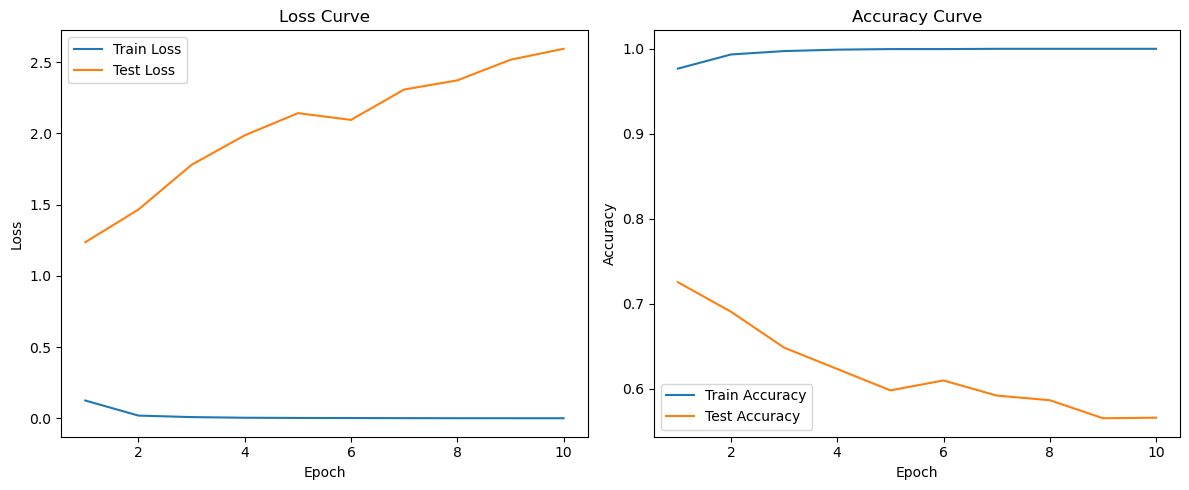

In [53]:
train_model(model, merged_train_loader, test_loader=test_loader, num_epochs=10, fine_tuning=True)

Training on cpu


Epoch [1/10]: 100%|██████████| 47/47 [00:00<00:00, 170.02batch/s, Loss=0.1401]


Epoch [1/10] - Train Loss: 0.1401, Train Acc: 0.9670, Test Loss: 1.4181, Test Acc: 0.7157


Epoch [2/10]: 100%|██████████| 47/47 [00:00<00:00, 247.48batch/s, Loss=0.0108]


Epoch [2/10] - Train Loss: 0.0108, Train Acc: 0.9970, Test Loss: 1.5668, Test Acc: 0.6873


Epoch [3/10]: 100%|██████████| 47/47 [00:00<00:00, 257.70batch/s, Loss=0.0030]


Epoch [3/10] - Train Loss: 0.0030, Train Acc: 1.0000, Test Loss: 1.6824, Test Acc: 0.6756


Epoch [4/10]: 100%|██████████| 47/47 [00:00<00:00, 257.17batch/s, Loss=0.0027]


Epoch [4/10] - Train Loss: 0.0027, Train Acc: 0.9990, Test Loss: 1.7723, Test Acc: 0.6665


Epoch [5/10]: 100%|██████████| 47/47 [00:00<00:00, 186.21batch/s, Loss=0.0011]


Epoch [5/10] - Train Loss: 0.0011, Train Acc: 1.0000, Test Loss: 1.9454, Test Acc: 0.6512


Epoch [6/10]: 100%|██████████| 47/47 [00:00<00:00, 187.18batch/s, Loss=0.0006]


Epoch [6/10] - Train Loss: 0.0006, Train Acc: 1.0000, Test Loss: 2.0681, Test Acc: 0.6404


Epoch [7/10]: 100%|██████████| 47/47 [00:00<00:00, 238.44batch/s, Loss=0.0005]


Epoch [7/10] - Train Loss: 0.0005, Train Acc: 1.0000, Test Loss: 2.1822, Test Acc: 0.6315


Epoch [8/10]: 100%|██████████| 47/47 [00:00<00:00, 194.85batch/s, Loss=0.0004]


Epoch [8/10] - Train Loss: 0.0004, Train Acc: 1.0000, Test Loss: 2.2739, Test Acc: 0.6271


Epoch [9/10]: 100%|██████████| 47/47 [00:00<00:00, 245.17batch/s, Loss=0.0003]


Epoch [9/10] - Train Loss: 0.0003, Train Acc: 1.0000, Test Loss: 2.3121, Test Acc: 0.6231


Epoch [10/10]: 100%|██████████| 47/47 [00:00<00:00, 153.47batch/s, Loss=0.0002]


Epoch [10/10] - Train Loss: 0.0002, Train Acc: 1.0000, Test Loss: 2.4332, Test Acc: 0.6178
Fine-tuning complete!


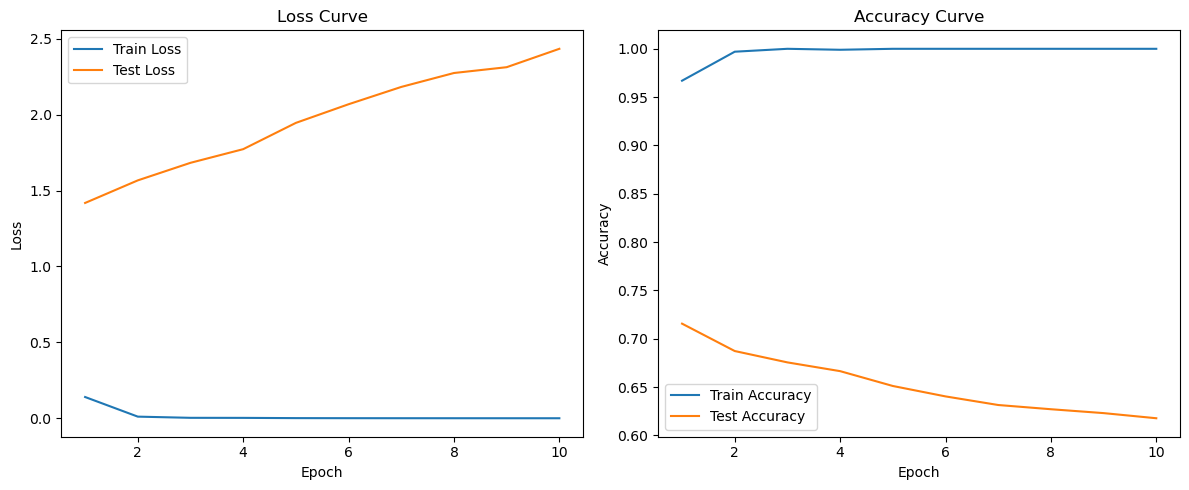

In [54]:
train_model(model_ann, merged_train_loader, test_loader=test_loader, num_epochs=10, fine_tuning=True)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      5952
           1       0.99      0.66      0.79      6791
           2       1.00      0.09      0.17      6026
           3       0.32      1.00      0.48      6084
           4       0.42      0.99      0.59      5780
           5       0.99      0.20      0.34      5454
           6       0.99      0.35      0.52      5957
           7       0.55      0.99      0.71      6231
           8       0.99      0.36      0.53      5890
           9       0.99      0.15      0.25      5835

    accuracy                           0.57     60000
   macro avg       0.82      0.56      0.53     60000
weighted avg       0.82      0.57      0.53     60000



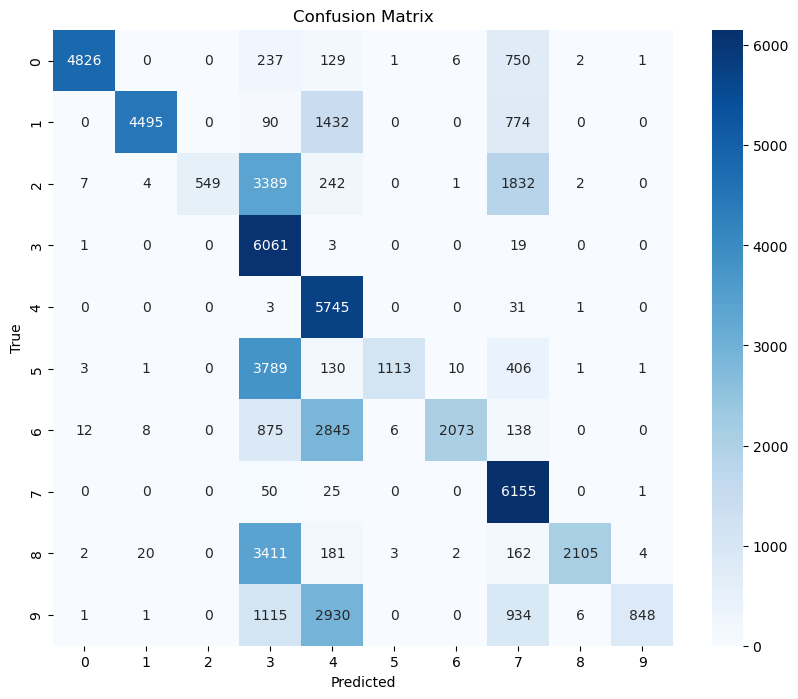

In [55]:
evaluate_model(model, test_loader)

Training on cpu
Classification report for test data:
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      5952
           1       0.99      0.59      0.74      6791
           2       1.00      0.22      0.36      6026
           3       0.34      1.00      0.51      6084
           4       0.47      0.99      0.64      5780
           5       0.94      0.44      0.60      5454
           6       0.99      0.66      0.79      5957
           7       0.59      0.99      0.74      6231
           8       0.95      0.26      0.41      5890
           9       1.00      0.12      0.21      5835

    accuracy                           0.62     60000
   macro avg       0.83      0.61      0.59     60000
weighted avg       0.83      0.62      0.60     60000



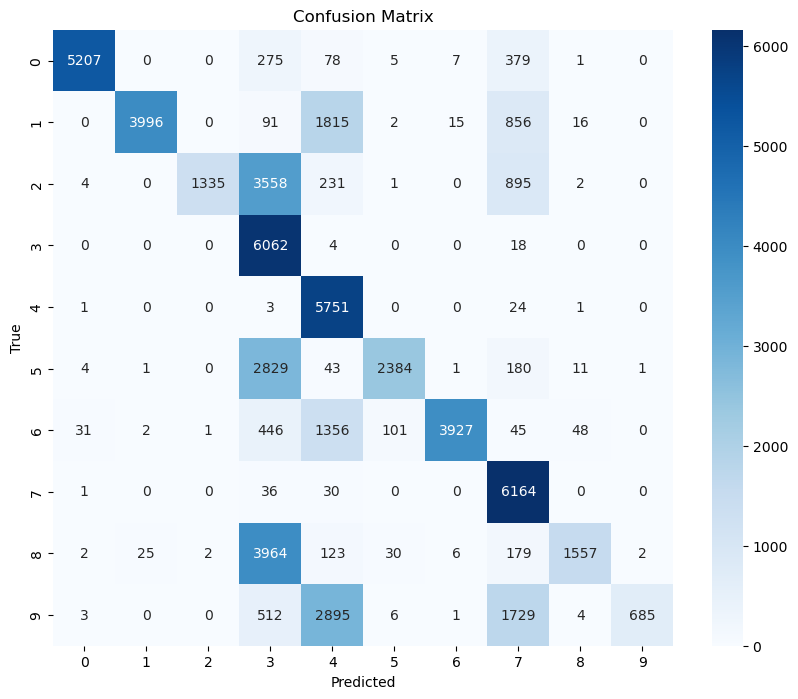

In [56]:
evaluate_model(model_ann, test_loader)

In [57]:
# Save the model
torch.save(mod.state_dict(), pretrained_model_path)
print("Model saved successfully!")

NameError: name 'mod' is not defined